In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

In [2]:
model_id = "ai-forever/rugpt3large_based_on_gpt2"

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

model =AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    quantization_config=bnb_config,
)

tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token

In [3]:
model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

In [4]:
def print_trainable_parameters(model):
  """
  Prints the number of trainable parameters in the model.
  """
  trainable_params = 0
  all_param = 0
  for _, param in model.named_parameters():
    all_param += param.numel()
    if param.requires_grad:
      trainable_params += param.numel()
  print(
      f"trainable params: {trainable_params} || all params: {all_param} || trainables%: {100 * trainable_params / all_param}"
  )

In [5]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 1536)
    (wpe): Embedding(2048, 1536)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-23): 24 x GPT2Block(
        (ln_1): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=1536, out_features=4608, bias=True)
          (c_proj): Linear4bit(in_features=1536, out_features=1536, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((1536,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=1536, out_features=6144, bias=True)
          (c_proj): Linear4bit(in_features=6144, out_features=1536, bias=True)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((1536,), eps=1e-05, element

## Lora Config

In [6]:
config = LoraConfig(
    r=64,
    lora_alpha=32,
    target_modules=["c_attn", "c_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, config)
print_trainable_parameters(model)

trainable params: 25952256 || all params: 446513664 || trainables%: 5.812197496379416


# Load Dataset (ru_instruct_gpt4)

In [7]:
def generate_prompt(data_point):
  return f"""
### Task: {data_point["instruction"]}
### Input: {data_point["input"]}
Output: {data_point["output"]}
""".strip()

In [8]:
data = load_dataset("lksy/ru_instruct_gpt4", split="train")
data = data.train_test_split(test_size=0.04)

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1461: FutureWarning: The repository for lksy/ru_instruct_gpt4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/lksy/ru_instruct_gpt4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [9]:
data

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output', 'full_output'],
        num_rows: 14453
    })
    test: Dataset({
        features: ['instruction', 'input', 'output', 'full_output'],
        num_rows: 603
    })
})

## Few examples

In [10]:
for i in range(10):
    tmp = data["train"][i]
    print(generate_prompt(tmp))
    print("-----------------------------")

### Task: Перескажи сюжет произведения "Война и мир" Льва Толстого.
### Input: 
Output: "Война и мир" Льва Толстого - это культовый роман, который описывает российское общество в период с 1805 по 1812 год. Сюжетная линия следует за судьбами аристократических семей Ростовых, Болконских и Безуховых, их отношениями, любовными исканиями и встречами с историческими событиями. Главное событие романа - это Отечественная война 1812 года, сражение с французскими войсками Наполеона и его последующим поражением, что стало мощным импульсом для национального возрождения России.
-----------------------------
### Task: Опиши ситуацию из жизни, когда применение силы аргументов оказалось более действенным, чем аргумент силы.
### Input: 
Output: Во время участия в студенческом проекте возник спор между двумя участниками группы о стратегии выполнения задачи. Один из участников, физически крупный парень, пытался настоять на своей точке зрения, используя аргумент силы, однако другой участник, хорошо подгот

In [11]:
ex_prompt = generate_prompt(tmp)
ex_prompt[ex_prompt.find("Output: ") + 8:]

'"Преступление и наказание" Ф.М. Достоевского - это произведение о внутреннем конфликте главного героя Родиона Раскольникова, который решает совершить убийство, считая себя надчеловеческой личностью, обладающей правом на такое деяние. В романе основное внимание уделяется моральному кризису Раскольникова, борьбе между совестью и гордостью, а также его общению с остальными персонажами, на протяжении всей истории ведущими его к исповеди и исканию искупления.'

In [12]:
class Dataset:
    def __init__(self, data):
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return {
            'instruction': (self.data[idx]['instruction'] + '\n' + self.data[idx]['input']).strip(),
            'output': self.data[idx]['output'].strip()
        }

In [13]:
def collate_fn(data):
    inputs, outputs = [], []
    
    for x in data:
        inp = f'### Задание: {x["instruction"]}\n\n### Ответ:'
        input_ids = tokenizer(
            inp,
            add_special_tokens=True
        )['input_ids']
        label_ids = tokenizer(
            x['output'] + tokenizer.eos_token,
            add_special_tokens=False,
            max_length=512,
            truncation=True
        )['input_ids']
        inputs.append(torch.tensor(input_ids + label_ids))
        outputs.append(torch.tensor([-100] * len(input_ids) + label_ids))
        
    input_ids = torch.nn.utils.rnn.pad_sequence(inputs, batch_first=True, padding_value=0)
    labels = torch.nn.utils.rnn.pad_sequence(outputs, batch_first=True, padding_value=-100)
        
    return {
        'input_ids': input_ids,
        'labels': labels,
        'attention_mask': input_ids.ne(0)
    }

In [14]:
train_dataset = Dataset(data['train'])
eval_dataset = Dataset(data['test'])

# Metrics setup and Training

In [15]:
import evaluate
import nltk

metric = evaluate.load('rouge')
def rouge_bleu_custom(pred):
    references = pred.label_ids
    predictions = pred.predictions[0]

    ref_sent = []
    pred_sent = []
    macro_bleu = 0
    for ref, predicted in zip(references, predictions):
        # replace -100 with pad token
        ref[ref == -100] = tokenizer.eos_token_id
        ref_decoded = tokenizer.decode(ref, skip_special_tokens=True)
        predicted[predicted == -100] = tokenizer.eos_token_id
        predicted_decoded = tokenizer.decode(predicted, skip_special_tokens=True)
        ref_sent.append(ref_decoded)
        pred_sent.append(predicted_decoded)
        
        bleu_score = nltk.translate.bleu_score.sentence_bleu(
                [ref_decoded],
                predicted_decoded,
                weights = [0.334, 0.333, 0.333]
        )
        macro_bleu += bleu_score
    metrics_dict = metric.compute(predictions=pred_sent, references=ref_sent)
    metrics_dict['bleu'] = macro_bleu / len(references)
    return metrics_dict

In [16]:
def preprocess_logits_for_metrics(logits, labels):
    """
    Original Trainer may have a memory leak. 
    This is a workaround to avoid storing too many tensors that are not needed.
    """

    pred_ids = torch.argmax(logits, dim=-1)
    return pred_ids, labels

In [17]:
training_args = transformers.TrainingArguments(
      per_device_train_batch_size=6,
      per_device_eval_batch_size=1,
      gradient_accumulation_steps=4,
      eval_accumulation_steps=4,
      num_train_epochs=5,
      learning_rate=2e-4,
      fp16=True,
      save_total_limit=3,
      output_dir="experiments",
      optim="paged_adamw_8bit",
      lr_scheduler_type="cosine",
      warmup_ratio=0.05,
      logging_dir = './logs',
      report_to = 'tensorboard',
      load_best_model_at_end = True,
      evaluation_strategy ='epoch',
      eval_steps=250,
      logging_strategy='steps',
      logging_steps=1,
      save_strategy='epoch',
      save_steps=2000,
      seed=42,
      remove_unused_columns=False,
)

trainer = transformers.Trainer(
    model,
    training_args,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=rouge_bleu_custom,
    data_collator=collate_fn,
    preprocess_logits_for_metrics=preprocess_logits_for_metrics,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Detected kernel version 4.15.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will

Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Bleu
0,1.863300,2.015756,0.169717,0.092373,0.167370,0.167742,0.480105
1,1.948600,1.965270,0.171252,0.088855,0.167642,0.168607,0.480183
2,1.843000,1.952126,0.171044,0.088072,0.166528,0.168249,0.477032
4,2.057000,1.938400,0.170484,0.087425,0.167087,0.167958,0.475642


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/torch/utils/checkpoint.py:460: UserWarning: torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended th

TrainOutput(global_step=3010, training_loss=2.0073553546322542, metrics={'train_runtime': 4697.628, 'train_samples_per_second': 15.383, 'train_steps_per_second': 0.641, 'total_flos': 4.834354143041741e+16, 'train_loss': 2.0073553546322542, 'epoch': 5.0})

## Check Model

In [1]:
import os
import bitsandbytes as bnb
import pandas as pd
import torch
import torch.nn as nn
import transformers
from datasets import load_dataset
from peft import (
    LoraConfig,
    PeftConfig,
    PeftModel,
    get_peft_model,
    prepare_model_for_kbit_training,
)
from transformers import (
    AutoConfig,
    AutoModelForCausalLM,
    AutoTokenizer,
    BitsAndBytesConfig,
)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
  
# using the style for the plot 
plt.style.use('dark_background') 
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"

/home/alm/miniforge3/envs/assistant_nlp/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    load_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16,
)

In [4]:
PEFT_MODEL = "../models/gpt2"

config = PeftConfig.from_pretrained(PEFT_MODEL)
model = AutoModelForCausalLM.from_pretrained(
    config.base_model_name_or_path,
    return_dict=True,
    quantization_config=bnb_config,
    device_map="auto",
)

tokenizer=AutoTokenizer.from_pretrained(config.base_model_name_or_path)
tokenizer.pad_token = tokenizer.eos_token

In [5]:
model = PeftModel.from_pretrained(model, PEFT_MODEL)

In [ ]:
output_len = []

for i in range(len(train_data)):
    output_len.append(len(train_data["output"][i]))
plt.hist(output_len)

In [6]:
data = load_dataset("lksy/ru_instruct_gpt4", split="train")
data = data.train_test_split(test_size=0.04)

/home/alm/miniforge3/envs/assistant_nlp/lib/python3.9/site-packages/datasets/load.py:1461: FutureWarning: The repository for lksy/ru_instruct_gpt4 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/lksy/ru_instruct_gpt4
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(array([4.712e+03, 4.725e+03, 3.754e+03, 1.072e+03, 1.570e+02, 2.500e+01,
        6.000e+00, 1.000e+00, 0.000e+00, 1.000e+00]),
 array([1.0000e+00, 1.9370e+02, 3.8640e+02, 5.7910e+02, 7.7180e+02,
        9.6450e+02, 1.1572e+03, 1.3499e+03, 1.5426e+03, 1.7353e+03,
        1.9280e+03]),
 <BarContainer object of 10 artists>)

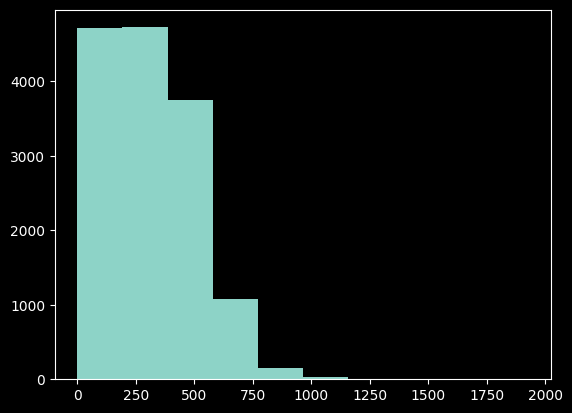

In [8]:
output_len = []

for i in range(len(data['train'])):
    output_len.append(len(data['train']["output"][i]))
plt.hist(output_len)

In [9]:
print(f"Median of Train Output Len: {np.median(output_len)}")
print(f"Mean of Train Output Len: {np.mean(output_len):.2f}")

Median of Train Output Len: 297.0
Mean of Train Output Len: 306.58


In [10]:
# Параметры для генерации
generation_params = {
    "max_new_tokens": 150,
    "num_beams": 3,
    "early_stopping": True,
    "no_repeat_ngram_size": 2,
    "eos_token_id": tokenizer.eos_token_id,
    "pad_token_id": tokenizer.eos_token_id,
}

## Рассмотрим обработку текстов из валидационного датасета

In [13]:
val_data = data['test']

for _ in range(10):
  i = np.random.randint(len(val_data))
  task = (val_data[i]['instruction'] + '\n' + val_data[i]['input']).strip()
  prompt = f'### Задание: {task}\n\n### Ответ:'
  original_prompt = f'### Задание: {task}\n\n### Ответ:'
  original_prompt += val_data[i]['output']

  device = "cuda:0"
  encoding = tokenizer(prompt, return_tensors="pt").to(device)
  with torch.inference_mode():
    outputs = model.generate(
        input_ids = encoding.input_ids,
        attention_mask = encoding.attention_mask,
        **generation_params,
  )
  pred_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
  # sequence_start = pred_text.find("Output: ") + 8
  print(pred_text)
  print("---------------------------------")
  print("Validation Output: " + val_data["output"][i])
  print("\n\n")

### Задание: Составьте анекдот на основе предложенных слов.
Бар, летучая мышь, бартендер

### Ответ:Бармен: "Уважаемые посетители, сегодня у нас необычный бар! Мы приготовили для вас сюрприз - летучую мышь!"
---------------------------------
Validation Output: Однажды вечером в бар заходит летучая мышь, садится на табуретку и заказывает пиво. Бартендер удивлённо смотрит на неё и спрашивает: "Ну и что ты, малышка, тут забыла?" Летучая мышь отвечает: "Ну, я пиво хотела выпить. Вино уже надоело, а крови капельки вообще не пробовала."



### Задание: Напиши рассказ о человеке, который вдруг обнаружил в себе удивительную способность.
Денис | способность разговаривать с животными

### Ответ:Однажды Денис случайно обнаружил, что может общаться с домашними животными. Однажды, гуляя по лесу, он встретил лису, которая рассказала ему о своих приключениях в лесу. Денис решил помочь лисе, и они вместе отправились на поиски пропавшего зайца. Когда они нашли его, заяц рассказал Денису о своей истории